# **Generation SG Junior Data Engineer Programme**
### **Interim Project presented by DPPS Team (5)**<br><span style="color:darkblue; font-weight:bold;">Members: Daniel | Pin Pin, Yvonne | Pin Yean, Erica | Shawn</span>


### <span style="color:darkblue; font-weight:bold;">Air Temperatures & Resale Flat Prices: Data Analysis</span>
<div>This documentation outlines our systematic approach to analysing the datasets which we have ingested from APIs and .CSVs from www.data.gov.sg, to derive actionable insights for analysis.

We ingested data on air temperature across singapore, relative humidity across singapore, and resale flat transactions.

For this analysis, we would be focused on using the relationship between air temperature and resale flat transactions.
</div>

### Analysis Problem Statement
Our Problem Statement: "How can we buy a flat in the coolest area of Singapore, at the best price?"

In our scenario, the buyer Daniel, would like to search for the coolest area of Singapore to buy his flat, because he does not like hot weather, and also wants to save on electricity bills. As such, we embark on analysis to attempt to answer the above question.

### Methodology
Using 4 SQL Queries, we look to answer the following questions: 

1. Where are the coolest HDB towns in Singapore?

2. What is the average price of each flat type in the coolest HDB town, over the past 1 year?

3. With all other factors of the flats being equal, how can I find the blocks with the latest 5 transactions average, which are less than the past 1 year average price? 

4. Input final conditions (flat type, remaining lease, storey range), to filter the blocks into a manageable number for searching on propertyguru.com and finally, viewings!

### Pre-Analysis Query

We began by trying to connect the data from the Air Temperature dataset to the Resale Flat Transactions dataset.
Doing so would help us to find answers to the above questions.

The first Pre-Analysis Query to map the station_name to the town_name, by joining the 2 tables created for this purpose, station and locations. 

Output: A list of station names and the town names which they are mapped to.  

```sql
SELECT 
	station_name, station.station_id, town_name
FROM 
	station
INNER JOIN
	locations
ON 
	station.station_id = locations.station_id; 
```

#### Pre-Analysis Output Result
<img src="https://raw.githubusercontent.com/shawnwch/repo2911/main/query 0 output.png" alt="Alt Text" width="800">

### Query 1
Query 1 looks to find out where are the coolest HDB towns in Singapore? 
The query derives the average annual temperature for each air temperature station, mapped to each town,
and subsequently orders them from the lowest to highest temperatures. 
For the purpose of this exercise, we would be using the HDB town Choa Chu Kang with lowest average temperature at 28.4 degrees.

Output: It would reflect a list of station ids, temperatures and town names, ordered from lowest to highest.

```sql
SELECT 
	air_temp.station_id, ROUND(AVG(temperature), 1) AS avg_annual_temperature, town_name
FROM 
	air_temp
INNER JOIN
	locations
ON 
	air_temp.station_id = locations.station_id
WHERE
	air_temp.airtemp_date >= '2023-12-01' AND
	air_temp.airtemp_date <= '2024-11-30'
GROUP BY 
	air_temp.station_id, town_name
ORDER BY 
	avg_annual_temperature ASC; 
```

#### Query 1 Output Result
<img src="https://raw.githubusercontent.com/shawnwch/repo2911/main/query 1 output.png" alt="Alt Text" width="800">

### Query 2
Query 2 looks to find out what is the average price of each flat type in each HDB town, over 1 year?
By having a list of the average price for each flat type (2 room, 3 room, 4 room, 5 room, Executive), we would be able to derive a 
benchmark price for the flat type which we would be looking to buy.

Output: It would reflect a list of flat types and their average resale prices in Choa Chu Kang.

```sql
SELECT
	town_name, 
	flat_type, TO_CHAR(AVG(resale_price), 'FM$999,999,990.00') AS avg_resale_price -- format as currency
FROM 
	resale_flat_txn
WHERE 
	town_name = 'CHOA CHU KANG' AND
	resale_date >= '2023-12-01' AND 
	resale_date <= '2024-11-30'
GROUP BY 
	town_name, flat_type
ORDER BY 
	AVG(resale_price); 
```

#### Query 2 Output Result
<img src="https://raw.githubusercontent.com/shawnwch/repo2911/main/query 2 output.png" alt="Alt Text" width="800">

### Query 3

With all other factors of the flats being equal, Query 3 looks to find out how can I find the blocks with the latest 5 transaction average prices which are less than the past 1 year average price? 

What is the reason behind using this condition for filtering?
1. Flat valuations are heavily dependent on past transacted prices, for eg. if your neighbour sells at a high price, congratulations to you!
2. Assuming property prices in SG generally go up, by right the latest 5 transactions should be higher than the average of the past 1 year,
but if I can find flats which transact in the last 5 transactions at prices less than the average of the past 1 year, looking at that particular block should offer a good deal, purely in terms of price. 

Output: A list of 307 rows, or blocks, which meet the above condition for filtering, in Choa Chu Kang. 

```sql
WITH avg_prices -- Calculate 1-year average resale price for each flat_type and town_name
    AS (
    SELECT 
        town_name, 
        flat_type, 
        AVG(resale_price) AS avg_resale_price
    FROM 
        resale_flat_txn
    WHERE 
        town_name = 'CHOA CHU KANG' AND
        resale_date >= '2023-12-01' AND
        resale_date <= '2024-11-30'
    GROUP BY 
        town_name, flat_type
),
fivetransaction_avg -- Calculate the 5 transaction average resale price
    AS (
    SELECT 
		resale_flat_txn.resale_date,
        resale_flat_txn.town_name,
        resale_flat_txn.flat_type,
        resale_flat_txn.block_no,
        resale_flat_txn.street_name,
		resale_flat_txn.storey_range,
        AVG(resale_flat_txn.resale_price) OVER ( -- OVER window function
            PARTITION BY resale_flat_txn.flat_type, resale_flat_txn.block_no, resale_flat_txn.street_name, resale_flat_txn.storey_range 
            ORDER BY resale_flat_txn.resale_date 
            ROWS BETWEEN 4 PRECEDING AND CURRENT ROW 
        ) AS fivetransaction_avg_resale_price        
    FROM                                             
        resale_flat_txn
    WHERE 
        resale_flat_txn.town_name = 'CHOA CHU KANG'
        AND resale_flat_txn.resale_date >= '2023-12-01' 
        AND resale_flat_txn.resale_date <= '2024-11-30'
)
SELECT 
	fivetransaction_avg.resale_date,
	fivetransaction_avg.town_name,
    fivetransaction_avg.flat_type,
    fivetransaction_avg.block_no,
    fivetransaction_avg.street_name,
	fivetransaction_avg.storey_range,
    TO_CHAR(fivetransaction_avg.fivetransaction_avg_resale_price, 'FM$999,999,990.00') AS fivetransaction_avg_resale_price,
    TO_CHAR(avg_prices.avg_resale_price, 'FM$999,999,990.00') AS avg_resale_price
FROM 
    fivetransaction_avg
JOIN 
    avg_prices
ON 
    fivetransaction_avg.town_name = avg_prices.town_name AND
    fivetransaction_avg.flat_type = avg_prices.flat_type
WHERE 
    fivetransaction_avg.fivetransaction_avg_resale_price < avg_prices.avg_resale_price AND -- latest 3 month average
    fivetransaction_avg.resale_date = (
        SELECT MAX(resale_date)
        FROM resale_flat_txn 
        WHERE resale_flat_txn.flat_type = fivetransaction_avg.flat_type
        AND resale_flat_txn.block_no = fivetransaction_avg.block_no
        AND resale_flat_txn.street_name = fivetransaction_avg.street_name
    )
ORDER BY 
    fivetransaction_avg.flat_type, fivetransaction_avg.resale_date DESC;
```

#### Query 3 Output Result
<img src="https://raw.githubusercontent.com/shawnwch/repo2911/main/query 3 output.png" alt="Alt Text" width="800">

### Query 4
Finally, once the latest 5 transaction average price is less than 1 year avg price,

Query 4 adds conditions for flat type, remaining lease and storey range to further filter for the appropriate blocks.
This allows us to filter it into a smaller set, which would make the process of shopping on propertyguru and subsequently viewings, easier.

Output: A list of 22 rows, or blocks, which meet the above condition for filtering, in Choa Chu Kang.

```sql
WITH avg_prices -- Calculate 1-year average resale price
    AS (
    SELECT 
        town_name, 
        flat_type, 
        AVG(resale_price) AS avg_resale_price
    FROM 
        resale_flat_txn
    WHERE 
        town_name = 'CHOA CHU KANG' AND
        resale_date >= '2023-12-01' AND
        resale_date <= '2024-11-30' AND
		flat_type = '4 ROOM' AND
		remaining_lease >= '85 years 00 months' AND -- add conditions
		storey_range NOT IN ('01 TO 03', '04 TO 06')
    GROUP BY 
        town_name, flat_type
),
fivetransaction_avg -- Calculate the 5 transaction average resale price
    AS (
    SELECT 
		resale_flat_txn.resale_date,
        resale_flat_txn.town_name,
        resale_flat_txn.flat_type,
        resale_flat_txn.block_no,
        resale_flat_txn.street_name,
		resale_flat_txn.storey_range,
        AVG(resale_flat_txn.resale_price) OVER ( -- OVER window function 
            PARTITION BY resale_flat_txn.flat_type, resale_flat_txn.block_no, resale_flat_txn.street_name, resale_flat_txn.storey_range 
            ORDER BY resale_flat_txn.resale_date 
            ROWS BETWEEN 4 PRECEDING AND CURRENT ROW 
        ) AS fivetransaction_avg_resale_price           
    FROM                                             
        resale_flat_txn
    WHERE 
        resale_flat_txn.town_name = 'CHOA CHU KANG' AND
        resale_flat_txn.resale_date >= '2023-12-01' AND
        resale_flat_txn.resale_date <= '2024-11-30' AND
		flat_type = '4 ROOM' AND
		remaining_lease >= '85 years 00 months' AND
		storey_range NOT IN ('01 TO 03', '04 TO 06')
)
SELECT 
	fivetransaction_avg.resale_date,
	fivetransaction_avg.town_name,
    fivetransaction_avg.flat_type,
    fivetransaction_avg.block_no,
    fivetransaction_avg.street_name,
	fivetransaction_avg.storey_range,
    TO_CHAR(fivetransaction_avg.fivetransaction_avg_resale_price, 'FM$999,999,990.00') AS fivetransaction_avg_resale_price,
    TO_CHAR(avg_prices.avg_resale_price, 'FM$999,999,990.00') AS avg_resale_price
FROM 
    fivetransaction_avg
JOIN 
    avg_prices
ON 
    fivetransaction_avg.town_name = avg_prices.town_name AND
    fivetransaction_avg.flat_type = avg_prices.flat_type
WHERE 
    fivetransaction_avg.fivetransaction_avg_resale_price < avg_prices.avg_resale_price AND -- latest 3 month average
    fivetransaction_avg.resale_date = (
        SELECT MAX(resale_date)
        FROM resale_flat_txn 
        WHERE resale_flat_txn.flat_type = fivetransaction_avg.flat_type
        AND resale_flat_txn.block_no = fivetransaction_avg.block_no
        AND resale_flat_txn.street_name = fivetransaction_avg.street_name
    )
ORDER BY 
    fivetransaction_avg.flat_type, fivetransaction_avg.resale_date DESC; 
```

#### Query 4 Output Result
<img src="https://raw.githubusercontent.com/shawnwch/repo2911/main/query 4 output.png" alt="Alt Text" width="800">

#### Possible Next Steps for Queries

Could look into to including Views and Indexes into the queries if feasible, to make it more repeatable for usage.

#### Python Script and Data Visualisation for Query 1
Here would be python script and visualisation done on the dataset with regards to Query 1, with yearly average temperatures for Choa Chu Kang, done in matplotlib.

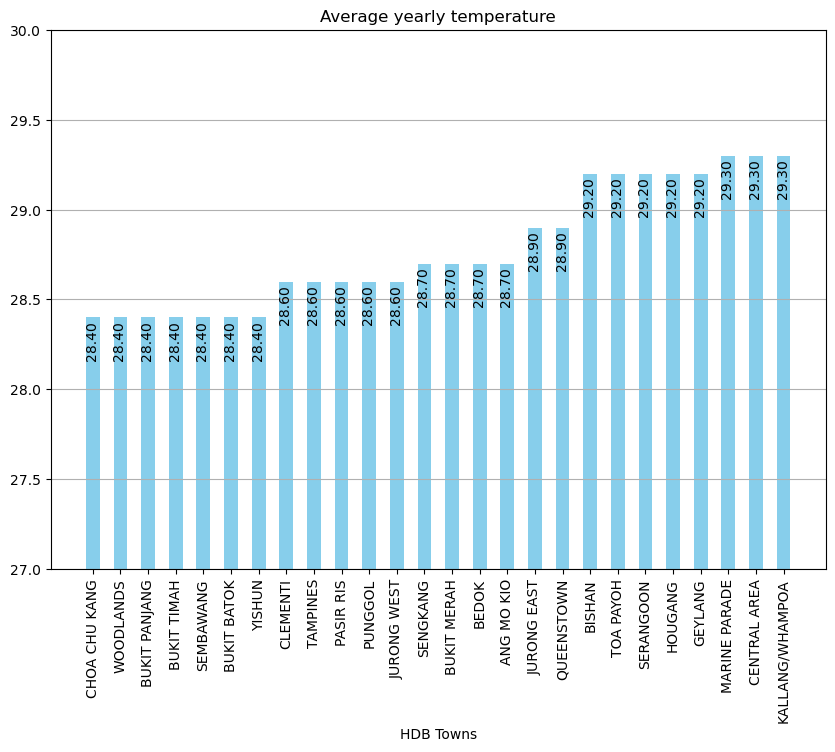

In [37]:
#Python script for Query 1 visualisation

import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine

#Database credentials - update these inputs for your local db's
DB_USER = 'postgres'
DB_PASS = 'password'
DB_HOST = 'localhost'
DB_PORT = '5432'
DB_NAME = 'data_gov_project'

#Connect to PostgreSQL
engine = create_engine(f'postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

#Select query
query = """ SELECT air_temp.station_id, ROUND(AVG(temperature), 1) AS avg_annual_temperature, town_name
            FROM air_temp
            INNER JOIN locations
            ON air_temp.station_id = locations.station_id
            WHERE air_temp.airtemp_date >= '2023-12-01' AND
                air_temp.airtemp_date <= '2024-11-30'
            GROUP BY air_temp.station_id, town_name
            ORDER BY avg_annual_temperature ASC; 
        """

#Read query results to dataframe
df = pd.read_sql_query(query, engine)

plt.figure(figsize=(10, 7))
bars = plt.bar(df['town_name'], df['avg_annual_temperature'], color='skyblue', width = 0.5)
plt.xlabel('HDB Towns')
plt.title('Average yearly temperature')
plt.xticks(rotation=90)
plt.grid(True, axis='y')

# Set y-axis range
plt.ylim(27, 30)

# Add text labels to the bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f'{height:,.2f} ',
        ha='center',
        va='top',
        rotation=90
    )

# Show the plot
plt.show()

<img src="https://raw.githubusercontent.com/shawnwch/repo2911/main/CCK avg temp.png" alt="Alt Text" width="800">

#### Python Script and Data Visualisation for Query 2
Here would be the python script and visualisation done on the dataset with regards to Query 2, with yearly average resale prices for Choa Chu Kang by flat type, done in matplotlib.

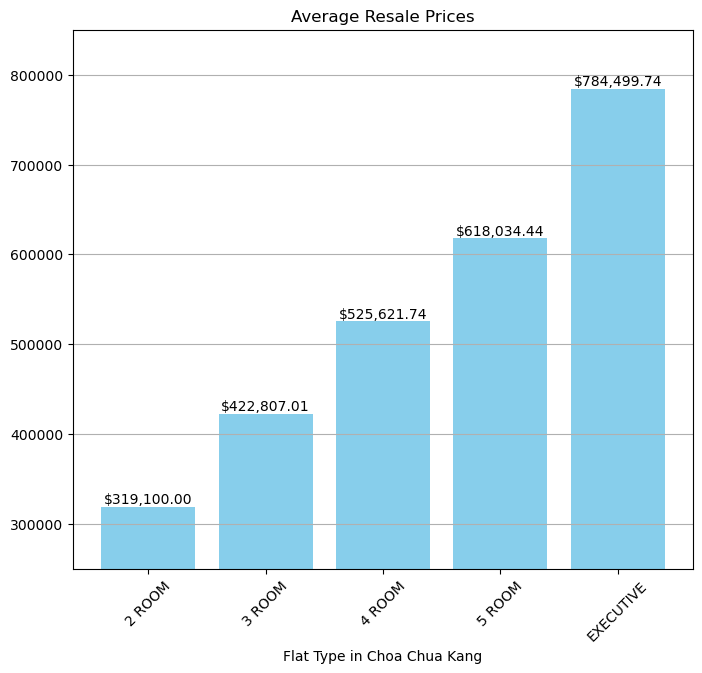

In [35]:
#Python code for Query 2 visualisation

import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine

#Database credentials - update these inputs for your local db's 
DB_USER = 'postgres'
DB_PASS = 'password'
DB_HOST = 'localhost'
DB_PORT = '5432'
DB_NAME = 'data_gov_project'

#Connect to PostgreSQL
engine = create_engine(f'postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

#Select query
query = """ SELECT
	town_name, 
	flat_type, AVG(resale_price) AS avg_resale_price 
FROM 
	resale_flat_txn
WHERE 
	town_name = 'CHOA CHU KANG' AND
	resale_date >= '2023-12-01' AND 
	resale_date <= '2024-11-30'
GROUP BY 
	town_name, flat_type
ORDER BY 
	AVG(resale_price); 
"""

#Read query results to dataframe
df = pd.read_sql_query(query, engine)


#Create bar chart
plt.figure(figsize=(8, 7))
bars = plt.bar(df['flat_type'], df['avg_resale_price'], color='skyblue')
plt.xlabel('Flat Type in Choa Chua Kang')
plt.title('Average Resale Prices')
plt.xticks(rotation=45)
plt.grid(True, axis='y')

#Set y-axis range
plt.ylim(250000, 850000)

#Add text labels to the bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f'${height:,.2f}', 
        ha='center',
        va='bottom' )

#Show the graph
plt.show()

<img src="https://raw.githubusercontent.com/shawnwch/repo2911/main/CCK avg resale prices.png" alt="Alt Text" width="800">